https://machinelearningmastery.com/regression-metrics-for-machine-learning/

https://datascience.stackexchange.com/questions/30912/what-does-baseline-mean-in-the-context-of-machine-learning

https://stats.stackexchange.com/questions/299712/what-are-the-shortcomings-of-the-mean-absolute-percentage-error-mape

https://stats.stackexchange.com/questions/78079/confidence-interval-of-rmse

# 0.0 Imports

In [1]:
import pandas as pd
import numpy  as np

import matplotlib.pyplot as plt

from sklearn.linear_model  import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree          import DecisionTreeRegressor
from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

## 0.1 Helper Functions

In [2]:
from src.helpers import ml_training, get_scores_regression, update_dataframe

In [3]:
def register_performance(model, name, X, y, df_score):
    
    # model predict
    yhat = model.predict(X)

    # model performance
    data = get_scores_regression(name, y, yhat)

    # updating dataframe
    df_score = update_dataframe(df_score, data)
    
    return df_score


def poly_fit(degree, X_train, X_val, X_test):
    polynomial = PolynomialFeatures(degree=degree)
    
    X_train = polynomial.fit_transform(X_train)
    X_val   = polynomial.transform(X_val)
    X_test  = polynomial.transform(X_test)
    
    return X_train, X_val, X_test

## 0.2 Load Dataset

In [4]:
df_train = pd.read_csv('data/regressao/X_training.csv')
df_val   = pd.read_csv('data/regressao/X_validation.csv')
df_test  = pd.read_csv('data/regressao/X_test.csv')

df_train.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,0.205673,0.092100,0.720,0.802,0.000000,0.090909,0.694,0.431778,1,0.0582,0.103876,0.8,0.723
1,-0.240409,0.737000,0.483,0.412,0.000000,0.636364,0.116,-0.262732,1,0.0402,1.711532,0.6,0.247
2,-0.125770,0.274000,0.671,0.565,0.000065,1.000000,0.370,0.013612,0,0.1600,1.009176,0.8,0.561
3,-0.580967,0.002340,0.704,0.529,0.874000,1.000000,0.370,-0.266382,0,0.0416,0.666173,0.8,0.507
4,-0.688566,0.000414,0.354,0.910,0.205000,0.090909,0.456,0.422914,1,0.0430,1.182630,0.8,0.362


In [5]:
y_train = pd.read_csv('data/regressao/y_training.csv').values.ravel()
y_val   = pd.read_csv('data/regressao/y_val.csv').values.ravel()
y_test  = pd.read_csv('data/regressao/y_test.csv').values.ravel()

y_train

array([79., 86., 63., ..., 39., 65., 34.])

In [6]:
# checando se todas as variáveis são numéricas
df_train.dtypes

song_duration_ms    float64
acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
key                 float64
liveness            float64
loudness            float64
audio_mode            int64
speechiness         float64
tempo               float64
time_signature      float64
audio_valence       float64
dtype: object

In [7]:
# checando se há valores nulos
df_train.isna().sum()

song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
dtype: int64

Como todos os valores são numéricos e não há valores nulos, podemos prosseguir com o treinamento dos algoritmos. Mas antes, vamos converter os dataframes em arrays.

In [8]:
X_train = df_train.values
X_val   = df_val.values
X_test  = df_test.values

X_train

array([[ 0.20567323,  0.0921    ,  0.72      , ...,  0.10387637,
         0.8       ,  0.723     ],
       [-0.2404085 ,  0.737     ,  0.483     , ...,  1.71153241,
         0.6       ,  0.247     ],
       [-0.12577046,  0.274     ,  0.671     , ...,  1.00917635,
         0.8       ,  0.561     ],
       ...,
       [-0.3978542 ,  0.515     ,  0.221     , ...,  2.02888064,
         0.8       ,  0.713     ],
       [ 0.84908529,  0.0681    ,  0.683     , ..., -0.62838795,
         0.8       ,  0.841     ],
       [-1.13234711,  0.31      ,  0.74      , ...,  0.30786603,
         0.8       ,  0.836     ]])

# 1.0 Algoritms

In [9]:
regression_columns = ['Algorithm', 'R2', 'MSE', 'RMSE', 'MAE', 'MAPE']

train_scores = pd.DataFrame(columns=regression_columns)
val_scores   = pd.DataFrame(columns=regression_columns)
test_scores  = pd.DataFrame(columns=regression_columns)

train_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE


Nesse ensaio serão avaliados as seguintes métricas de regressão nos conjuntos de treino, validação e teste:

* $R^2 = 1 - \frac{\text{SSE}}{\text{SST}}$

    * Onde:
    
    * $\text{SSE} = \sum_{i}^{N} (y_i -\hat{y_i})^2$
    
    * $\text{SST} = \sum_{i}^{N} (y_i -\bar{y})^2$


* $\text{MSE} = \frac{1}{N}\sum_{i=1}^{N}(y_i - \hat{y_i})^2$


* $\text{RMSE} = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(y_i - \hat{y_i})^2}$


* $\text{MAE} = \frac{1}{N}\sum_{i=1}^{N} |y_i - \hat{y_i}|$


* $\text{MAPE} = \frac{1}{N}\sum_{i=1}^{N}\left| \frac{y_i - \hat{y_i}}{y_i} \right|$

Em problemas de regressão, ao contrário de classificação, não é possível calcular a acurácia dos modelos; ao invés disso, as métricas acima nos dizem o quão próximo, em média, as predições $\hat{y}$ ficaram do valor real $y$. 

Todas essas métricas de erro retornam um número real, o qual precisamos comparar com um modelo baseline para verificar o quanto cada tipo algoritmo conseguiu melhorar a capacidade preditiva em relação ao modelo mais simples. Em outras palavras, o baseline nós diz qual é "nível" de aprendizado mínimo aceitável que o modelo pode ter, e qualquer valor menor que ele indica que o modelo não está conseguindo aprender tarefa a partir dos dados, sendo mais vantajoso utilizar o modelo baseline do que o algoritmo de Machine Learning. 

Nesse ensaio vamos usar como baseline a média dos targets dos dados de treinamento.

## 1.0 Baseline

In [10]:
from sklearn.dummy import DummyRegressor

baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train, y_train)

DummyRegressor()

In [11]:
# baseline performance conjunto de treinamento
train_scores = register_performance(baseline, 'Baseline', X_train, y_train, train_scores)
train_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,0.0,478.01256,21.863498,17.36509,8.742213


In [12]:
# baseline performance conjunto de validação
val_scores = register_performance(baseline, 'Baseline', X_val, y_val, val_scores)
val_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-7.197077e-07,477.511956,21.852047,17.352836,8.678722


In [13]:
# baseline performance conjunto de test
test_scores = register_performance(baseline, 'Baseline', X_test, y_test, test_scores)
test_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-0.000124,486.961469,22.067203,17.551492,8.71455


## 1.1 Linear Regression

O algoritmo de regressão linear, implementado pela classe `LinearRegression`, é usado para prever um valor de um target numérico, representado pela variável dependente $y$, a partir de variáveis $x_i$ independentes. Nesse algoritmo estamos em busca de um conjunto de coeficientes $\theta_i$ que produz um reta/plano/hiperplano que minimiza uma função de custo. Na prática, na regressão linear estamos interessados em determinar a melhor função $\hat{y} = f(\vec{x})$ que minimiza a função $\text{Cost}$, a qual, por razões de optimização, é definida como sendo metade do $\text{MSE}$:

$\hat{y} = f(\vec{x}) = f(x_{1}, x_{2}, ..., x_{n}) = \; \theta_0 + \theta_1x_{1} + \theta_2x_{2} + ... + \theta_nx_{n} \;= \theta_0 + \sum_{i=1}^{N}\theta_ix_{i}$

<br/>

$\text{Cost}(y, \hat{y}) = \frac{1}{2}\;\text{MSE} = \frac{1}{2N}\sum_{i=1}^{N}(y_i - \hat{y_i})^2$

$\text{Cost}(y, \hat{y}) = \frac{1}{2N}\sum_{i=1}^{N}(y_i - f(\vec{x_i}))^2$

A regressão linear vai encontrar os valores dos parâmetros $(\theta_0, \theta_1, \theta_2, ..., \theta_n)$ que minimizam o $\text{Cost}(y, \hat{y})$:

$\text{Cost}(y, \hat{y}) = \frac{1}{2N}\sum_{i=1}^{N}(y_i - \;\;\left[ \theta_0 + \theta_1x_{i1} + \theta_2x_{i2} + ... + \theta_nx_{in} \right] \;\; )^2$

Nesse algoritmo não temos nenhum parâmetro para ajustar.

### 1.1.1 Fine-tuning

In [14]:
lr_scores = ml_training(LinearRegression, 'regression', X_train, y_train, X_val, y_val)
lr_scores

,name,R2,MSE,RMSE,MAE,MAPE
0,LinearRegression,0.039925,458.447042,21.411376,17.039754,8.682542


### 1.1.2 Performance

In [15]:
# model definition
lr = LinearRegression()

# model fit
lr.fit(X_train, y_train)

LinearRegression()

In [16]:
# coeficientes theta que minimizaram a função de erro
lr.coef_

array([ -0.20046868,  -3.65696235,  13.56830825, -10.08825907,
        -9.92988105,  -0.86974806,  -4.85538987,   2.49422937,
        -0.22283834,  -1.77163857,  -0.39798578,   7.31483515,
        -9.46824939])

**Training**

In [17]:
train_scores = register_performance(lr, 'Linear Regression', X_train, y_train, train_scores)
train_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,0.000000,478.012560,21.863498,17.365090,8.742213
1,Linear Regression,0.046058,455.996112,21.354065,16.998249,8.653186


**Validation**

In [18]:
val_scores = register_performance(lr, 'Linear Regression', X_val, y_val, val_scores)
val_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-7.197077e-07,477.511956,21.852047,17.352836,8.678722
1,Linear Regression,3.992483e-02,458.447042,21.411376,17.039754,8.682542


**Test**

In [19]:
test_scores = register_performance(lr, 'Linear Regression', X_test, y_test, test_scores)
test_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-0.000124,486.961469,22.067203,17.551492,8.714550
1,Linear Regression,0.052317,461.427719,21.480869,17.129965,8.521859


## 1.2 Decision Tree Regressor

O algoritmo Decision Tree Regressor, implementado pela classe `DecisionTreeRegressor`, segmenta o conjunto de dados de treinamento em subgrupos baseado em um par (feature, valor) que mínimiza uma medida de impureza nos subconjuntos resultantes. Esse processo de subdivisão da árvores (criação de galhos) é repetido até que todos os nós (subconjunto no final de cada galho) sejam 100% puros ou um dos critérios de parada seja atingido.

O valor do target predito pela árvore para um novo ponto (ainda não visto) será atribuído seguindo os galhos da árvore para identificar em qual nó esse ponto pertence, e o seu valor será dado pela média aritmética dos targets das observações presentes nesse nó.

Parâmetros para se ajustar:

* `max_depth`= profundidade máxima da árvore.

### 1.2.1 Fine-tuning

In [20]:
tree_scores = ml_training(
                            DecisionTreeRegressor, 
                            'regression', 
                            X_train, y_train, X_val, y_val, 
                            max_depth=np.arange(1, 30, 1)
                )

tree_scores

,name,max_depth,R2,MSE,RMSE,MAE,MAPE
0,DecisionTreeRegressor,1,0.025733,465.223863,21.569049,17.122340,8.549934
1,DecisionTreeRegressor,2,0.037609,459.552983,21.437187,16.985102,8.480125
2,DecisionTreeRegressor,3,0.054812,451.338427,21.244727,16.896550,8.469922
3,DecisionTreeRegressor,4,0.062168,447.825853,21.161896,16.849288,8.536141
4,DecisionTreeRegressor,5,0.063559,447.161319,21.146189,16.843452,8.395778
5,DecisionTreeRegressor,6,0.063296,447.286802,21.149156,16.748081,8.324423
6,DecisionTreeRegressor,7,0.058373,449.637594,21.204660,16.724101,7.997308
7,DecisionTreeRegressor,8,0.037910,459.409230,21.433834,16.873933,7.914855
8,DecisionTreeRegressor,9,0.021382,467.301470,21.617157,16.878253,7.880247
9,DecisionTreeRegressor,10,-0.004142,479.489599,21.897251,16.859819,7.878171


Para facilitar a visualização, vamos ver como o valor da métrica $R^{2}$ se comportou em relação ao `max_depth`, apenas quando $R^{2} > 0$ (situação que o modelo é melhor que o baseline).

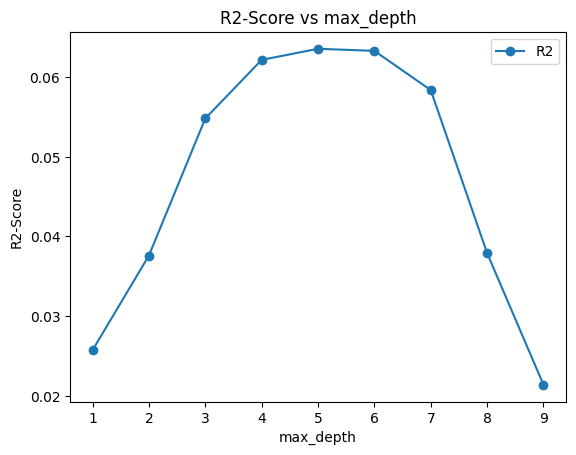

In [21]:
ax = tree_scores.loc[tree_scores['R2'] > 0].plot(x='max_depth', y='R2', style='-o')

ax.set_ylabel('R2-Score')
ax.set_title('R2-Score vs max_depth');

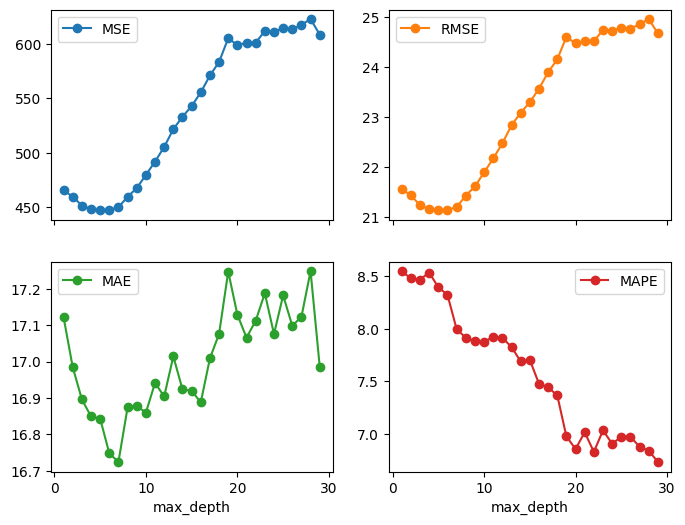

In [22]:
tree_scores.drop('R2', axis=1).plot(x='max_depth', style='-o', subplots=True, layout=(2, 2), figsize=(8, 6));

In [23]:
tree_bestR2 = tree_scores.loc[tree_scores['R2'].idxmax()]
tree_bestR2

name         DecisionTreeRegressor
max_depth                        5
R2                        0.063559
MSE                     447.161319
RMSE                     21.146189
MAE                      16.843452
MAPE                      8.395778
Name: 4, dtype: object

### 1.2.2 Performance

In [24]:
import cv2
from sklearn import tree as tr

In [25]:
# model definition
tree = DecisionTreeRegressor(max_depth=tree_bestR2['max_depth'])

# model fit
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5)

In [26]:
tr.export_graphviz(
    tree,                                    # modelo treinado
    out_file='tree_regressor.dot',           # nome do arquivo exportado
    feature_names=df_train.columns,          # nome das features
    rounded=True,                            # quando settamos para 'True' indicamos que queremos borda arredondada
)

# comando que converte o arquivo 'tree.dot' em um arquivo png chamado de 'tree.png'
!dot -Tpng tree_regressor.dot -o tree_regressor.png

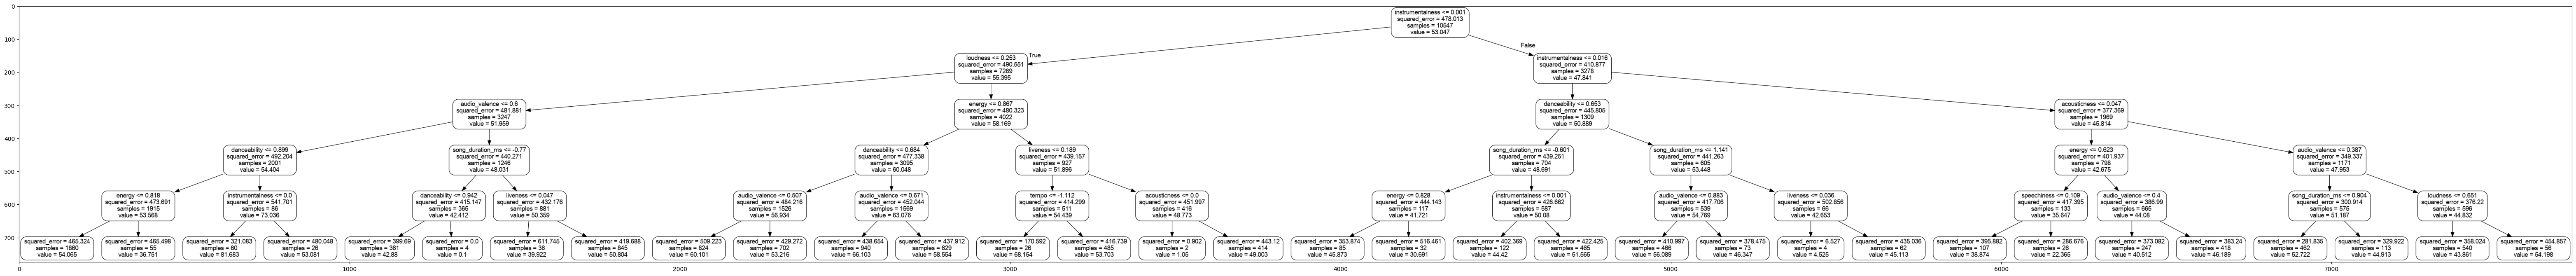

In [27]:
img = cv2.imread('tree_regressor.png')

plt.figure(figsize=(80, 20))
plt.imshow(img);

**Training**

In [28]:
train_scores = register_performance(tree, 'Decision Tree', X_train, y_train, train_scores)
train_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,0.000000,478.012560,21.863498,17.365090,8.742213
1,Linear Regression,0.046058,455.996112,21.354065,16.998249,8.653186
2,Decision Tree,0.113523,423.747268,20.585122,16.368766,7.869536


**Validation**

In [29]:
val_scores = register_performance(tree, 'Decision Tree', X_val, y_val, val_scores)
val_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-7.197077e-07,477.511956,21.852047,17.352836,8.678722
1,Linear Regression,3.992483e-02,458.447042,21.411376,17.039754,8.682542
2,Decision Tree,6.355928e-02,447.161319,21.146189,16.843452,8.395778


**Test**

In [30]:
test_scores = register_performance(tree, 'Decision Tree', X_test, y_test, test_scores)
test_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-0.000124,486.961469,22.067203,17.551492,8.714550
1,Linear Regression,0.052317,461.427719,21.480869,17.129965,8.521859
2,Decision Tree,0.072181,451.755789,21.254547,17.010757,7.833952


## 1.3 Random Forest Regressor

O algoritmo Random Forest Regressor, implementado pela classe `RandomForestRegressor`, treina um número definido de árvores de decisão e faz a previsão para uma nova observação usando a média dos valores atribuídos a ela por cada árvore. Nesse algoritmo, o treinamento de cada árvore é feito por um número menor de features, de modo que cada estimador visualize apenas um parte do fenômeno; a idéia é que a predição seja feita utilizando diferentes perspectivas, de forma a reduzir o viés durante o treinamento, e assim gerar uma predição mais robusta.

Parâmetros para se ajustar:

* `n_estimators` = número de árvores treinadas.
* `max_depth` = profundiade máxima de cada árvore.

### 1.3.1 Fine-tuning

In [31]:
rf_scores = ml_training(
                            RandomForestRegressor,
                            'regression',
                            X_train, y_train, X_val, y_val,
                            n_estimators=np.arange(150, 250, 10),
                            max_depth=np.arange(25, 60, 5)
            )

rf_scores

,name,n_estimators,max_depth,R2,MSE,RMSE,MAE,MAPE
0,RandomForestRegressor,150,25,0.338211,316.011829,17.776722,12.988757,7.035435
1,RandomForestRegressor,150,30,0.334539,317.765321,17.825973,12.994846,7.023551
2,RandomForestRegressor,150,35,0.333861,318.089005,17.835050,12.997688,7.033589
3,RandomForestRegressor,150,40,0.336575,316.793130,17.798683,12.984685,7.026512
4,RandomForestRegressor,150,45,0.339739,315.282267,17.756190,12.927722,7.052934
...,...,...,...,...,...,...,...,...
65,RandomForestRegressor,240,35,0.335235,317.433001,17.816650,12.985687,7.063836
66,RandomForestRegressor,240,40,0.340393,314.969847,17.747390,12.939376,7.049797
67,RandomForestRegressor,240,45,0.339045,315.613662,17.765519,12.965956,7.037544
68,RandomForestRegressor,240,50,0.337289,316.452170,17.789103,12.958040,7.051076


In [32]:
#rf_scores.to_csv('output/regression/random_forest.csv', index=False)
rf_scores = pd.read_csv('output/regression/random_forest.csv')

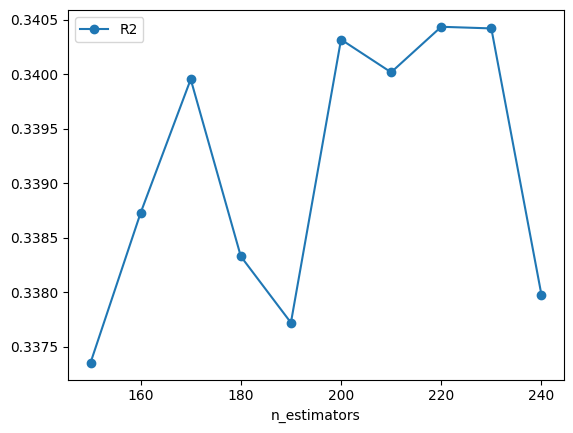

In [33]:
# grafico de R2 vs n_estimators com maiores valores de R2  para cada max_depth
rf_scores.groupby('n_estimators').max().reset_index().plot(x='n_estimators', y='R2', style='-o');

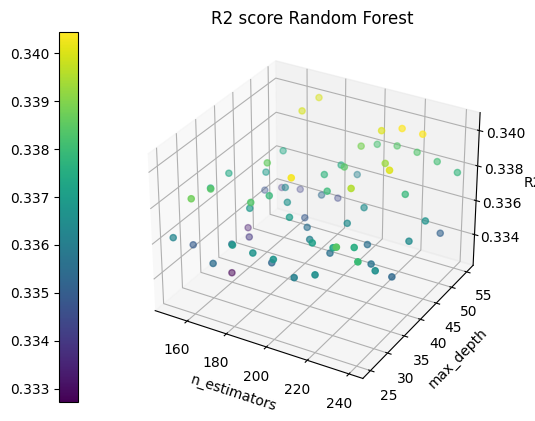

In [34]:
ax = plt.figure().add_subplot(projection='3d')

x = rf_scores['n_estimators']
y = rf_scores['max_depth']
z = rf_scores['R2']

scatter_plot = ax.scatter3D(xs=x, ys=y, zs=z, c=z)
plt.colorbar(scatter_plot, location='left')

ax.set_title('R2 score Random Forest')
ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('R2');

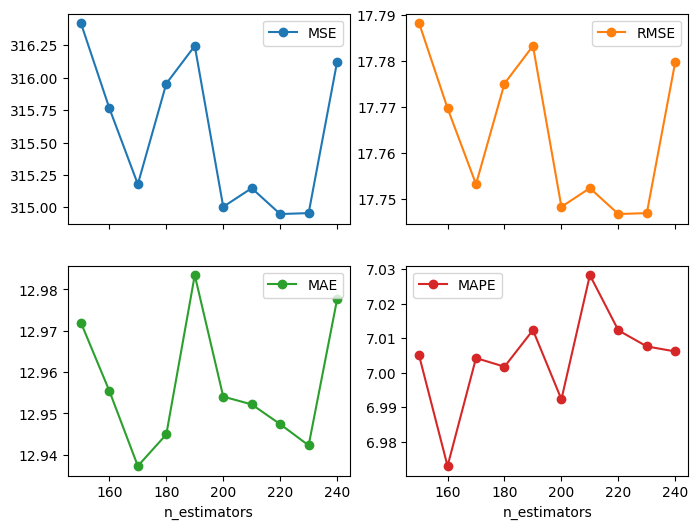

In [35]:
# determina os scores mínimo para cada número de estimadores (variando o max_depth)
rf_aux = rf_scores.drop(['max_depth','R2'], axis=1).groupby('n_estimators').min().reset_index()

rf_aux.plot(x='n_estimators', style='-o', subplots=True, layout=(2, 2), figsize=(8, 6));

In [36]:
rf_bestR2 = rf_scores.loc[rf_scores['R2'].idxmax()]
rf_bestR2

name            RandomForestRegressor
n_estimators                      220
max_depth                          50
R2                           0.340437
MSE                        314.949044
RMSE                        17.746804
MAE                         12.975753
MAPE                         7.012279
Name: 54, dtype: object

### 1.3.2 Performance

In [37]:
# model definition
rf = RandomForestRegressor(n_estimators=rf_bestR2['n_estimators'], max_depth=rf_bestR2['max_depth'])

# model fit
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, n_estimators=220)

**Training**

In [38]:
train_scores = register_performance(rf, 'Random Forest', X_train, y_train, train_scores)
train_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,0.000000,478.012560,21.863498,17.365090,8.742213
1,Linear Regression,0.046058,455.996112,21.354065,16.998249,8.653186
2,Decision Tree,0.113523,423.747268,20.585122,16.368766,7.869536
3,Random Forest,0.905269,45.282648,6.729238,4.819884,2.614952


**Validation**

In [39]:
val_scores = register_performance(rf, 'Random Forest', X_val, y_val, val_scores)
val_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-7.197077e-07,477.511956,21.852047,17.352836,8.678722
1,Linear Regression,3.992483e-02,458.447042,21.411376,17.039754,8.682542
2,Decision Tree,6.355928e-02,447.161319,21.146189,16.843452,8.395778
3,Random Forest,3.371453e-01,316.520801,17.791031,13.008747,7.019370


**Test**

In [40]:
test_scores = register_performance(rf, 'Random Forest', X_test, y_test, test_scores)
test_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-0.000124,486.961469,22.067203,17.551492,8.714550
1,Linear Regression,0.052317,461.427719,21.480869,17.129965,8.521859
2,Decision Tree,0.072181,451.755789,21.254547,17.010757,7.833952
3,Random Forest,0.356790,313.179616,17.696882,12.981922,6.545300


## 1.4 Polynomial Regression

O algoritmo Polynomial Regression, implementado calculando-se os termos de uma polinômio via classe `PolynomialFeatures` e treinando os valores resultantes com a classe `LinearRegression`, procura qual é o polinômio que melhor prediz o target a partir das variáveis explicativas (independentes). Na prática, fazemos uma transformação com o conjunto de treinamento e criando um novo conjunto com "novas features" que representam os termos cruzados de uma polinômio ( $x_1x_2$, $\;x_1^{2}x_2$, $\;x_{1}x_{2}x_3^{2}$, $\;x_1^{2}$, ... ), sendo esse novo conjunto utilizado para treinar uma regressão linear.

$\hat{y} = f(x_1, x_2 ... , x_n) = \beta_0 + 
(\beta_1x_1 + \beta_2x_2 + \;... + \beta_nx) + 
(\beta_{n+1}x_1^2 + \beta_{n+2}x_2^2 + \;...\; \beta_{2n}x_n^2 + \beta_{2n+1}x_1x_2 + \beta_{2n+2}x_1x_3 \;+\; ...\;) 
\; + \;... $

Partindo da função $f(x_1, x_2 ... , x_n)$ definida acima, nosso objetivo é, assim como ocorria na regressão linear convencional, determinar os parâmetros $(\beta_0, \beta_1, \beta_2, ...)$ que minimizam a função de custo $\text{Cost}(y, \hat{y})$:

$\text{Cost}(y, \hat{y}) = \frac{1}{2N}\sum_{i=1}^{N}(y_i - \hat{y_i})^2$

$\text{Cost}(y, \hat{y}) = \frac{1}{2N}\sum_{i=1}^{N}(y_i - f(\vec{x_i}))^2$

Parâmetros para se ajustar:

* `degree` = grau do polinômio de uma regressão linear

### 1.4.1 Fine-tuning

Vamos treinar o modelo para polinômios até o grau 4, pois conforme vamos aumentando o grau do polinômio o número de termos cruzados aumenta-se consideravelmente, aumentando também o tempo treinamento. Além disso, a regressão linear é um algoritmo que possui uma tendência de overfit para polinômios de grau alto; podemos atestar isso na tabela de treinamento, vemos que para $k=4$ obtemos $R^{2} \approx -100$, o que nos diz que o modelo produz predições no conjunto de validação muito piores que o modelo baseline (média dos pontos), um sinal claro de overfit.

In [41]:
poly_scores = ml_training(
                            LinearRegression, 
                            'regression',
                            X_train, y_train, X_val, y_val,
                            degree=np.arange(1, 5, 1)
                )

poly_scores

,name,degree,R2,MSE,RMSE,MAE,MAPE
0,LinearRegression,1,0.039925,458.447042,21.411376,17.039754,8.682542
1,LinearRegression,2,0.066477,445.768223,21.113224,16.749939,8.547931
2,LinearRegression,3,-0.047778,500.326254,22.367974,17.087201,8.678283
3,LinearRegression,4,-102.923632,49624.740827,222.766112,36.104220,10.184801


In [42]:
best_polyR2 = poly_scores.loc[poly_scores['R2'].idxmax()]
best_polyR2

name      LinearRegression
degree                   2
R2                0.066477
MSE             445.768223
RMSE             21.113224
MAE              16.749939
MAPE              8.547931
Name: 1, dtype: object

### 1.4.2 Performance

In [43]:
degree = best_polyR2['degree']

X_train_poly, X_val_poly, X_test_poly = poly_fit(degree, X_train, X_val, X_test)


# model definition
polynomial = LinearRegression()

# model fit
polynomial.fit(X_train_poly, y_train)

LinearRegression()

In [44]:
# Nesse caso como implementamos uma regressão polinomial de segunda ordem (k=2) para 13 features originais, o
# algoritmo 'LinearRegression()' ajustou 105 coeficientes beta.

# theta0   -> beta0       =  1
# theta1's -> betas*x     = 13
# theta2's -> betas*x^2   = 13
# theta3's -> betas*xi*xj = 78 ( termos cruzados - combinação 2 a 2 das features x_i's -> C(13, 2) = 78 )
# ----------------------------
#                   betas = 105

polynomial.coef_.shape

(105,)

**Training**

In [45]:
train_scores = register_performance(polynomial, 'Polynomial Regression', X_train_poly, y_train, train_scores)
train_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,0.000000,478.012560,21.863498,17.365090,8.742213
1,Linear Regression,0.046058,455.996112,21.354065,16.998249,8.653186
2,Decision Tree,0.113523,423.747268,20.585122,16.368766,7.869536
3,Random Forest,0.905269,45.282648,6.729238,4.819884,2.614952
4,Polynomial Regression,0.094195,432.986210,20.808321,16.458032,8.350540


**Validation**

In [46]:
val_scores = register_performance(polynomial, 'Polynomial Regression', X_val_poly, y_val, val_scores)
val_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-7.197077e-07,477.511956,21.852047,17.352836,8.678722
1,Linear Regression,3.992483e-02,458.447042,21.411376,17.039754,8.682542
2,Decision Tree,6.355928e-02,447.161319,21.146189,16.843452,8.395778
3,Random Forest,3.371453e-01,316.520801,17.791031,13.008747,7.019370
4,Polynomial Regression,6.647668e-02,445.768223,21.113224,16.749939,8.547931


**Test**

In [47]:
test_scores = register_performance(polynomial, 'Polynomial Regression', X_test_poly, y_test, test_scores)
test_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-0.000124,486.961469,22.067203,17.551492,8.714550
1,Linear Regression,0.052317,461.427719,21.480869,17.129965,8.521859
2,Decision Tree,0.072181,451.755789,21.254547,17.010757,7.833952
3,Random Forest,0.356790,313.179616,17.696882,12.981922,6.545300
4,Polynomial Regression,0.090079,443.041256,21.048545,16.720535,8.242464


## 1.5 Linear Regression Lasso

O algoritmo Linear Regression Lasso, implementado pela classe `Lasso`, introduz uma penalidade a função de custo da regressão linear, de modo a evitar que os parâmetros do modelo $(\theta_0, \theta_1, ..., \theta_n)$ se tornem muito grandes.

$\text{Cost}_{\;\text{lasso}}(y, \hat{y}) = (1/2)\;\text{MSE} + \lambda_1\sum_{i}^{n}|{\theta_i}|$

$\text{Cost}_{\;\text{lasso}}(y, \hat{y}) = \frac{1}{2N}\left( \sum_{i=1}^{N}(y_i - \hat{y_i})^2 \right) + \lambda_1\sum_{i}^{n}|{\theta_i}|$

$\text{Cost}_{\;\text{lasso}}(y, \hat{y}) = \frac{1}{2N}\left( \sum_{i=1}^{N}(y_i - f(\vec{x_i}))^2 \right) + \lambda_1\sum_{i}^{n}|{\theta_i}|$

Parâmetros para se estimar:

* `alpha` = parâmetro que controla a força de regularização (valor de $\lambda_1$ na formula acima)
* `max_iter` = número máximo de iterações permitido para encontrar uma solução.

### 1.5.1 Fine-tuning

In [48]:
lasso_scores = ml_training(
                            Lasso,
                            'regression',
                            X_train, y_train, X_val, y_val,
                            alpha=np.linspace(0.1, 1, 10),
                            max_iter=np.arange(100, 1000, 100)
                )

lasso_scores

,name,alpha,max_iter,R2,MSE,RMSE,MAE,MAPE
0,Lasso,0.1,100,0.037195,459.750411,21.441791,17.047448,8.686903
1,Lasso,0.1,200,0.037195,459.750411,21.441791,17.047448,8.686903
2,Lasso,0.1,300,0.037195,459.750411,21.441791,17.047448,8.686903
3,Lasso,0.1,400,0.037195,459.750411,21.441791,17.047448,8.686903
4,Lasso,0.1,500,0.037195,459.750411,21.441791,17.047448,8.686903
...,...,...,...,...,...,...,...,...
85,Lasso,1.0,500,0.007884,473.747081,21.765732,17.264922,8.695808
86,Lasso,1.0,600,0.007884,473.747081,21.765732,17.264922,8.695808
87,Lasso,1.0,700,0.007884,473.747081,21.765732,17.264922,8.695808
88,Lasso,1.0,800,0.007884,473.747081,21.765732,17.264922,8.695808


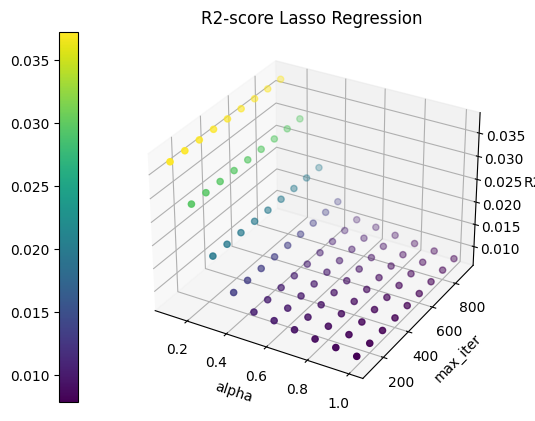

In [49]:
ax = plt.figure().add_subplot(projection='3d')

x = lasso_scores['alpha']
y = lasso_scores['max_iter']
z = lasso_scores['R2']

scatter_plot = ax.scatter3D(xs=x, ys=y, zs=z, c=z)
plt.colorbar(scatter_plot, location='left')

ax.set_title('R2-score Lasso Regression')
ax.set_xlabel('alpha')
ax.set_ylabel('max_iter')
ax.set_zlabel('R2');

In [50]:
best_lassoR2 = lasso_scores.loc[lasso_scores['R2'].idxmax()]
best_lassoR2

name             Lasso
alpha              0.1
max_iter           100
R2            0.037195
MSE         459.750411
RMSE         21.441791
MAE          17.047448
MAPE          8.686903
Name: 0, dtype: object

### 1.5.2 Performance

In [51]:
# model definition
lasso = Lasso(alpha=best_lassoR2['alpha'], max_iter=best_lassoR2['max_iter'])

# model fit
lasso.fit(X_train, y_train)

Lasso(alpha=0.1, max_iter=100)

Com uma inspeção rápida podemos confirmar que de fato os coefiecientes $\theta_i$ calculados via Linear Regression Lasso possuem o módulo menor. 

$|\theta{i}_{\text{Lasso}}| < |\theta{i}|$

In [52]:
# coeficientes regressao linear
lr.coef_

array([ -0.20046868,  -3.65696235,  13.56830825, -10.08825907,
        -9.92988105,  -0.86974806,  -4.85538987,   2.49422937,
        -0.22283834,  -1.77163857,  -0.39798578,   7.31483515,
        -9.46824939])

In [53]:
# coeficientes regressao linear lasso
lasso.coef_

array([-0.13010997, -0.81070428, 10.52549616, -4.03403154, -8.17882846,
       -0.        , -1.07532663,  2.00412668, -0.        , -0.        ,
       -0.42567393,  0.        , -7.54325801])

**Training**

In [54]:
train_scores = register_performance(lasso, 'Linear Regression Lasso', X_train, y_train, train_scores)
train_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,0.000000,478.012560,21.863498,17.365090,8.742213
1,Linear Regression,0.046058,455.996112,21.354065,16.998249,8.653186
2,Decision Tree,0.113523,423.747268,20.585122,16.368766,7.869536
3,Random Forest,0.905269,45.282648,6.729238,4.819884,2.614952
4,Polynomial Regression,0.094195,432.986210,20.808321,16.458032,8.350540
5,Linear Regression Lasso,0.041219,458.309397,21.408162,17.046776,8.667964


**Validation**

In [55]:
val_scores = register_performance(lasso, 'Linear Regression Lasso', X_val, y_val, val_scores)
val_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-7.197077e-07,477.511956,21.852047,17.352836,8.678722
1,Linear Regression,3.992483e-02,458.447042,21.411376,17.039754,8.682542
2,Decision Tree,6.355928e-02,447.161319,21.146189,16.843452,8.395778
3,Random Forest,3.371453e-01,316.520801,17.791031,13.008747,7.019370
4,Polynomial Regression,6.647668e-02,445.768223,21.113224,16.749939,8.547931
5,Linear Regression Lasso,3.719533e-02,459.750411,21.441791,17.047448,8.686903


**Test**

In [56]:
test_scores = register_performance(lasso, 'Linear Regression Lasso', X_test, y_test, test_scores)
test_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-0.000124,486.961469,22.067203,17.551492,8.714550
1,Linear Regression,0.052317,461.427719,21.480869,17.129965,8.521859
2,Decision Tree,0.072181,451.755789,21.254547,17.010757,7.833952
3,Random Forest,0.356790,313.179616,17.696882,12.981922,6.545300
4,Polynomial Regression,0.090079,443.041256,21.048545,16.720535,8.242464
5,Linear Regression Lasso,0.044728,465.122726,21.566704,17.175600,8.592947


## 1.6 Linear Regression Ridge

O algoritmo Linear Regression Ridge, implementado pela classe `Ridge`, introduz uma penalidade a função de custo da regressão linear que eleva os parâmetros $\theta_i$ ao quadrado, de modo a incentivar que os parâmetros possuam baixas magnitudes, penalizando possiveis soluções que possuam ao menos um parâmetro $\theta_i$ com alto valor.

$\text{Cost}_{\;\text{ridge}}(y, \hat{y}) = (1/2)\;\text{MSE} + \lambda_2\sum_{i}^{n}({\theta_i})^2$

$\text{Cost}_{\;\text{ridge}}(y, \hat{y}) = \frac{1}{2N}\left( \sum_{i=1}^{N}(y_i - \hat{y_i})^2 \right) + \lambda_2\sum_{i}^{n}({\theta_i})^2$

$\text{Cost}_{\;\text{ridge}}(y, \hat{y}) = \frac{1}{2N}\left( \sum_{i=1}^{N}(y_i - f(\vec{x_i}))^2 \right) + \lambda_2\sum_{i}^{n}({\theta_i})^2$

Parâmetros para se estimar:

* `alpha` = parâmetro que controla a força de regularização (valor de $\lambda_2$ na fórmula acima)
* `max_iter` = número máximo de iterações permitido para encontrar uma solução.

### 1.6.1 Fine-tuning

In [68]:
ridge_scores = ml_training(
                            Ridge, 
                            'regression', 
                            X_train, y_train, X_val, y_val, 
                            alpha=np.linspace(0.1, 20, 10), 
                            max_iter=np.arange(100, 1000, 100)
                )

ridge_scores

,name,alpha,max_iter,R2,MSE,RMSE,MAE,MAPE
0,Ridge,0.1,100,0.039925,458.446874,21.411373,17.039725,8.682529
1,Ridge,0.1,200,0.039925,458.446874,21.411373,17.039725,8.682529
2,Ridge,0.1,300,0.039925,458.446874,21.411373,17.039725,8.682529
3,Ridge,0.1,400,0.039925,458.446874,21.411373,17.039725,8.682529
4,Ridge,0.1,500,0.039925,458.446874,21.411373,17.039725,8.682529
...,...,...,...,...,...,...,...,...
85,Ridge,20.0,500,0.039912,458.453172,21.411520,17.036139,8.680292
86,Ridge,20.0,600,0.039912,458.453172,21.411520,17.036139,8.680292
87,Ridge,20.0,700,0.039912,458.453172,21.411520,17.036139,8.680292
88,Ridge,20.0,800,0.039912,458.453172,21.411520,17.036139,8.680292


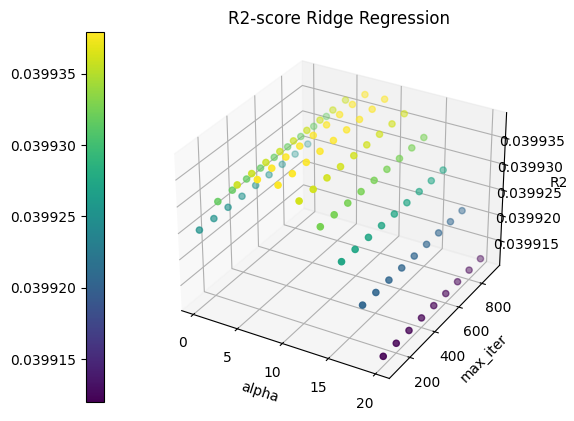

In [69]:
ax = plt.figure().add_subplot(projection='3d')

x = ridge_scores['alpha']
y = ridge_scores['max_iter']
z = ridge_scores['R2']

scatter_plot = ax.scatter3D(xs=x, ys=y, zs=z, c=z)
plt.colorbar(scatter_plot, location='left')

ax.set_title('R2-score Ridge Regression')
ax.set_xlabel('alpha')
ax.set_ylabel('max_iter')
ax.set_zlabel('R2');

In [70]:
best_ridgeR2 = ridge_scores.loc[ridge_scores['R2'].idxmax()]
best_ridgeR2

name            Ridge
alpha        8.944444
max_iter          100
R2           0.039938
MSE          458.4408
RMSE        21.411231
MAE         17.037793
MAPE         8.681461
Name: 36, dtype: object

### 1.6.2 Performance

In [60]:
# model definition
ridge = Ridge(alpha=best_ridgeR2['alpha'], max_iter=best_ridgeR2['max_iter'])

# model fit
ridge.fit(X_train, y_train)

Ridge(alpha=8.944444444444443, max_iter=100)

In [64]:
ridge.coef_

array([-0.20582584, -3.58034907, 13.06011235, -9.75425699, -9.77032218,
       -0.8774897 , -4.77807978,  2.47514852, -0.23357216, -1.43811757,
       -0.4164372 ,  5.97326037, -9.2352613 ])

**Training**

In [61]:
train_scores = register_performance(ridge, 'Linear Regression Ridge', X_train, y_train, train_scores)
train_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,0.000000,478.012560,21.863498,17.365090,8.742213
1,Linear Regression,0.046058,455.996112,21.354065,16.998249,8.653186
2,Decision Tree,0.113523,423.747268,20.585122,16.368766,7.869536
3,Random Forest,0.905269,45.282648,6.729238,4.819884,2.614952
4,Polynomial Regression,0.094195,432.986210,20.808321,16.458032,8.350540
5,Linear Regression Lasso,0.041219,458.309397,21.408162,17.046776,8.667964
6,Linear Regression Ridge,0.046018,456.015424,21.354518,16.999016,8.655050


**Validation**

In [62]:
val_scores = register_performance(ridge, 'Linear Regression Ridge', X_val, y_val, val_scores)
val_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-7.197077e-07,477.511956,21.852047,17.352836,8.678722
1,Linear Regression,3.992483e-02,458.447042,21.411376,17.039754,8.682542
2,Decision Tree,6.355928e-02,447.161319,21.146189,16.843452,8.395778
3,Random Forest,3.371453e-01,316.520801,17.791031,13.008747,7.019370
4,Polynomial Regression,6.647668e-02,445.768223,21.113224,16.749939,8.547931
5,Linear Regression Lasso,3.719533e-02,459.750411,21.441791,17.047448,8.686903
6,Linear Regression Ridge,3.993790e-02,458.440800,21.411231,17.037793,8.681461


**Test**

In [63]:
test_scores = register_performance(ridge, 'Linear Regression Ridge', X_test, y_test, test_scores)
test_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-0.000124,486.961469,22.067203,17.551492,8.714550
1,Linear Regression,0.052317,461.427719,21.480869,17.129965,8.521859
2,Decision Tree,0.072181,451.755789,21.254547,17.010757,7.833952
3,Random Forest,0.356790,313.179616,17.696882,12.981922,6.545300
4,Polynomial Regression,0.090079,443.041256,21.048545,16.720535,8.242464
5,Linear Regression Lasso,0.044728,465.122726,21.566704,17.175600,8.592947
6,Linear Regression Ridge,0.052199,461.485049,21.482203,17.128327,8.529799


## 1.7 Linear Regression Elastic Net

O algoritmo Linear Regression Elastic Net, implementado pela classe `ElasticNet`, quando queremos fazer uso das duas penalidades vistas anteriormente.

$\text{Cost}_{\;\text{elastic}}(y, \hat{y}) = (1/2)\;\text{MSE} + \lambda_1\sum_{i}^{n}|{\theta_i}| + \lambda_2\sum_{i}^{n}({\theta_i})^2$

$\text{Cost}_{\;\text{elastic}}(y, \hat{y}) = \frac{1}{2N}\left( \sum_{i=1}^{N}(y_i - \hat{y_i})^2 \right) + \lambda_1\sum_{i}^{n}|{\theta_i}| + \lambda_2\sum_{i}^{n}({\theta_i})^2$

$\text{Cost}_{\;\text{elastic}}(y, \hat{y}) = \frac{1}{2N}\left( \sum_{i=1}^{N}(y_i - f(\vec{x_i}))^2 \right) + \lambda_1\sum_{i}^{n}|{\theta_i}| + \lambda_2\sum_{i}^{n}({\theta_i})^2$

Parâmetros para se estimar (a biblioteca sklearn implementa a função de custo de maneira diferente):

* `alpha` = constante que multiplica os termos de penalidade ($\alpha = \lambda_1 + \lambda_2$)
* `l1_ratio` = parâmetro que define a proporção entre as penalidades L1 e L2 ( $L_1 = \lambda_1 \;/\; (\lambda_1 + \lambda_2)$ )
* `max_iter` = número máximo de iterações usados para encontrar uma solução.

### 1.7.1 Fine-tuning

In [71]:
elastic_scores = ml_training(
                                ElasticNet, 
                                'regression', X_train, y_train, X_val, y_val,
                                alpha=np.linspace(0.1, 1, 10),
                                l1_ratio=np.linspace(0.1, 1, 10),
                                max_iter=np.arange(1000, 2000, 100)
                    )

elastic_scores

,name,alpha,l1_ratio,max_iter,R2,MSE,RMSE,MAE,MAPE
0,ElasticNet,0.1,0.1,1000,0.025559,465.306951,21.570975,17.121044,8.677026
1,ElasticNet,0.1,0.1,1100,0.025559,465.306951,21.570975,17.121044,8.677026
2,ElasticNet,0.1,0.1,1200,0.025559,465.306951,21.570975,17.121044,8.677026
3,ElasticNet,0.1,0.1,1300,0.025559,465.306951,21.570975,17.121044,8.677026
4,ElasticNet,0.1,0.1,1400,0.025559,465.306951,21.570975,17.121044,8.677026
...,...,...,...,...,...,...,...,...,...
995,ElasticNet,1.0,1.0,1500,0.007884,473.747081,21.765732,17.264922,8.695808
996,ElasticNet,1.0,1.0,1600,0.007884,473.747081,21.765732,17.264922,8.695808
997,ElasticNet,1.0,1.0,1700,0.007884,473.747081,21.765732,17.264922,8.695808
998,ElasticNet,1.0,1.0,1800,0.007884,473.747081,21.765732,17.264922,8.695808


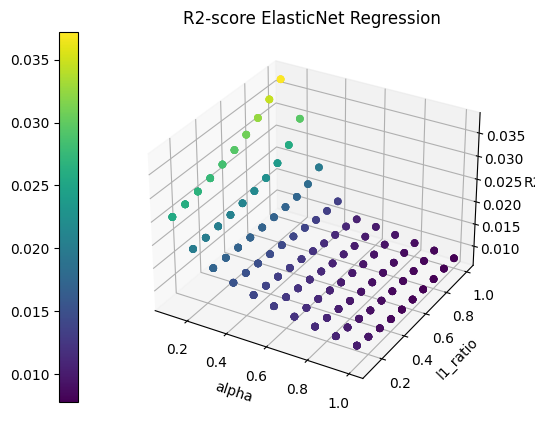

In [72]:
ax = plt.figure().add_subplot(projection='3d')

x = elastic_scores['alpha']
y = elastic_scores['l1_ratio']
z = elastic_scores['R2']

scatter_plot = ax.scatter3D(xs=x, ys=y, zs=z, c=z)
plt.colorbar(scatter_plot, location='left')

ax.set_title('R2-score ElasticNet Regression')
ax.set_xlabel('alpha')
ax.set_ylabel('l1_ratio')
ax.set_zlabel('R2');

In [73]:
best_elastic_R2 = elastic_scores.loc[elastic_scores['R2'].idxmax()]
best_elastic_R2

name        ElasticNet
alpha              0.1
l1_ratio           1.0
max_iter          1000
R2            0.037195
MSE         459.750411
RMSE         21.441791
MAE          17.047448
MAPE          8.686903
Name: 90, dtype: object

### 1.7.2 Performance

In [74]:
# model definition
elastic = ElasticNet(
                        alpha=best_elastic_R2['alpha'], 
                        l1_ratio=best_elastic_R2['l1_ratio'], 
                        max_iter=best_elastic_R2['max_iter']
                )

# model training
elastic.fit(X_train, y_train)

ElasticNet(alpha=0.1, l1_ratio=1.0)

**Training**

In [75]:
train_scores = register_performance(elastic, 'Linear Regression Elastic Net', X_train, y_train, train_scores)
train_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,0.000000,478.012560,21.863498,17.365090,8.742213
1,Linear Regression,0.046058,455.996112,21.354065,16.998249,8.653186
2,Decision Tree,0.113523,423.747268,20.585122,16.368766,7.869536
3,Random Forest,0.905269,45.282648,6.729238,4.819884,2.614952
4,Polynomial Regression,0.094195,432.986210,20.808321,16.458032,8.350540
5,Linear Regression Lasso,0.041219,458.309397,21.408162,17.046776,8.667964
6,Linear Regression Ridge,0.046018,456.015424,21.354518,16.999016,8.655050
7,Linear Regression Elastic Net,0.041219,458.309397,21.408162,17.046776,8.667964


**Validation**

In [76]:
val_scores = register_performance(elastic, 'Linear Regression Elastic Net', X_val, y_val, val_scores)
val_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-7.197077e-07,477.511956,21.852047,17.352836,8.678722
1,Linear Regression,3.992483e-02,458.447042,21.411376,17.039754,8.682542
2,Decision Tree,6.355928e-02,447.161319,21.146189,16.843452,8.395778
3,Random Forest,3.371453e-01,316.520801,17.791031,13.008747,7.019370
4,Polynomial Regression,6.647668e-02,445.768223,21.113224,16.749939,8.547931
5,Linear Regression Lasso,3.719533e-02,459.750411,21.441791,17.047448,8.686903
6,Linear Regression Ridge,3.993790e-02,458.440800,21.411231,17.037793,8.681461
7,Linear Regression Elastic Net,3.719533e-02,459.750411,21.441791,17.047448,8.686903


**Test**

In [77]:
test_scores = register_performance(elastic, 'Linear Regression Elastic Net', X_test, y_test, test_scores)
test_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-0.000124,486.961469,22.067203,17.551492,8.714550
1,Linear Regression,0.052317,461.427719,21.480869,17.129965,8.521859
2,Decision Tree,0.072181,451.755789,21.254547,17.010757,7.833952
3,Random Forest,0.356790,313.179616,17.696882,12.981922,6.545300
4,Polynomial Regression,0.090079,443.041256,21.048545,16.720535,8.242464
5,Linear Regression Lasso,0.044728,465.122726,21.566704,17.175600,8.592947
6,Linear Regression Ridge,0.052199,461.485049,21.482203,17.128327,8.529799
7,Linear Regression Elastic Net,0.044728,465.122726,21.566704,17.175600,8.592947


## 1.8 Polynomial Regression Lasso

O algoritmo Polynomial Regression Lasso vai ser implementado calculando-se os termos de um polinômio via classe `PolynomialFeatures` e treinando os valores resultantes com a classe `Lasso`.

Parâmetros para se estimar:

* `degree` = grau do polinômio da regressão polinomial.
* `alpha` = parâmetro que controla a força de regularização L1 Lasso ($\lambda_1$)
* `max_iter` = número máximo de iterações permitida durante busca pelos melhores parâmetros.

### 1.8.1 Fine-tuning

In [78]:
poly_lasso_scores = ml_training(
                                    Lasso,
                                    'regression', X_train, y_train, X_val, y_val,
                                    degree=[1,2,3],
                                    alpha=np.linspace(0.1, 1, 10),
                                    max_iter=np.arange(1000, 2000, 200)
                    )

poly_lasso_scores

,name,degree,alpha,max_iter,R2,MSE,RMSE,MAE,MAPE
0,Lasso,1,0.1,1000,0.037195,459.750411,21.441791,17.047448,8.686903
1,Lasso,1,0.1,1200,0.037195,459.750411,21.441791,17.047448,8.686903
2,Lasso,1,0.1,1400,0.037195,459.750411,21.441791,17.047448,8.686903
3,Lasso,1,0.1,1600,0.037195,459.750411,21.441791,17.047448,8.686903
4,Lasso,1,0.1,1800,0.037195,459.750411,21.441791,17.047448,8.686903
...,...,...,...,...,...,...,...,...,...
145,Lasso,3,1.0,1000,0.014148,470.755769,21.696907,17.180595,8.655828
146,Lasso,3,1.0,1200,0.014148,470.755769,21.696907,17.180595,8.655828
147,Lasso,3,1.0,1400,0.014148,470.755769,21.696907,17.180595,8.655828
148,Lasso,3,1.0,1600,0.014148,470.755769,21.696907,17.180595,8.655828


In [80]:
# calcula a media das métricas de erro para os diferentes valores de 'max_iter' presente nos grupos ('alpha', 'degree')
lasso_aux = poly_lasso_scores.groupby(['alpha', 'degree']).mean(numeric_only=True).reset_index()

# tabela com os valores médios de R2 para cada par ('alpha', 'degree')
pivot_lasso = pd.pivot_table(lasso_aux[['alpha', 'degree', 'R2']], index='alpha', columns='degree', values='R2')
pivot_lasso

degree,1,2,3
alpha,,,
0.1,0.037195,0.058898,0.058886
0.2,0.029583,0.049224,0.051524
0.3,0.019806,0.037815,0.038491
0.4,0.013253,0.024419,0.020931
0.5,0.010364,0.017592,0.014421
0.6,0.009890,0.016167,0.014995
0.7,0.009322,0.014399,0.014768
0.8,0.008738,0.012426,0.014863
0.9,0.008331,0.010746,0.014806


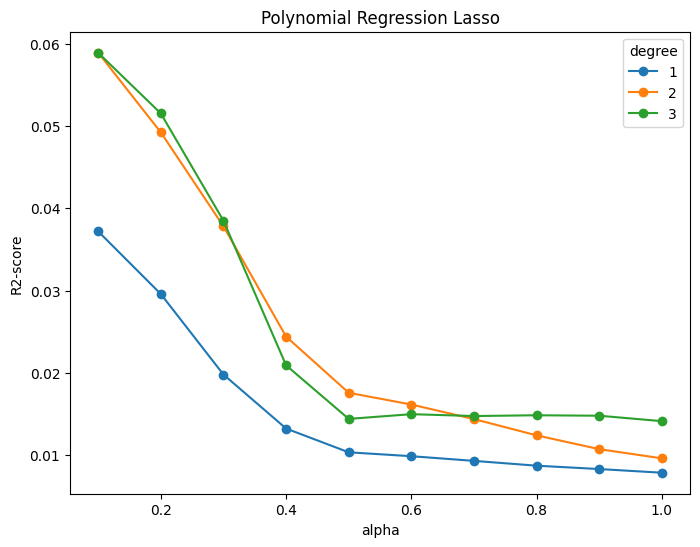

In [81]:
# plot da tabela 'pivot_lasso' com os indices no eixo x ('alpha') e um plot para cada coluna no eixo y contendo os
# valores do r2-score para cada degree.
pivot_lasso.plot(style='-o', xlabel='alpha', ylabel='R2-score', title='Polynomial Regression Lasso', figsize=(8, 6));

In [82]:
bestpoly_lassoR2 = poly_lasso_scores.loc[poly_lasso_scores['R2'].idxmax()]
bestpoly_lassoR2

name            Lasso
degree              2
alpha             0.1
max_iter         1000
R2           0.058898
MSE         449.38696
RMSE        21.198749
MAE         16.818893
MAPE         8.667648
Name: 50, dtype: object

### 1.8.2 Performance

In [83]:
degree = bestpoly_lassoR2['degree']

X_train_poly, X_val_poly, X_test_poly = poly_fit(degree, X_train, X_val, X_test)

# model definition
polylasso = Lasso(alpha=bestpoly_lassoR2['alpha'], max_iter=bestpoly_lassoR2['max_iter'])

# model fit
polylasso.fit(X_train_poly, y_train)

Lasso(alpha=0.1)

**Training**

In [84]:
train_scores = register_performance(polylasso, 'Polynomial Regression Lasso', X_train_poly, y_train, train_scores)
train_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,0.000000,478.012560,21.863498,17.365090,8.742213
1,Linear Regression,0.046058,455.996112,21.354065,16.998249,8.653186
2,Decision Tree,0.113523,423.747268,20.585122,16.368766,7.869536
3,Random Forest,0.905269,45.282648,6.729238,4.819884,2.614952
4,Polynomial Regression,0.094195,432.986210,20.808321,16.458032,8.350540
5,Linear Regression Lasso,0.041219,458.309397,21.408162,17.046776,8.667964
6,Linear Regression Ridge,0.046018,456.015424,21.354518,16.999016,8.655050
7,Linear Regression Elastic Net,0.041219,458.309397,21.408162,17.046776,8.667964
8,Polynomial Regression Lasso,0.067909,445.551320,21.108087,16.743258,8.556924


**Validation**

In [85]:
val_scores = register_performance(polylasso, 'Polynomial Regression Lasso', X_val_poly, y_val, val_scores)
val_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-7.197077e-07,477.511956,21.852047,17.352836,8.678722
1,Linear Regression,3.992483e-02,458.447042,21.411376,17.039754,8.682542
2,Decision Tree,6.355928e-02,447.161319,21.146189,16.843452,8.395778
3,Random Forest,3.371453e-01,316.520801,17.791031,13.008747,7.019370
4,Polynomial Regression,6.647668e-02,445.768223,21.113224,16.749939,8.547931
5,Linear Regression Lasso,3.719533e-02,459.750411,21.441791,17.047448,8.686903
6,Linear Regression Ridge,3.993790e-02,458.440800,21.411231,17.037793,8.681461
7,Linear Regression Elastic Net,3.719533e-02,459.750411,21.441791,17.047448,8.686903
8,Polynomial Regression Lasso,5.889836e-02,449.386960,21.198749,16.818893,8.667648


**Test**

In [86]:
test_scores = register_performance(polylasso, 'Polynomial Regression Lasso', X_test_poly, y_test, test_scores)
test_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-0.000124,486.961469,22.067203,17.551492,8.714550
1,Linear Regression,0.052317,461.427719,21.480869,17.129965,8.521859
2,Decision Tree,0.072181,451.755789,21.254547,17.010757,7.833952
3,Random Forest,0.356790,313.179616,17.696882,12.981922,6.545300
4,Polynomial Regression,0.090079,443.041256,21.048545,16.720535,8.242464
5,Linear Regression Lasso,0.044728,465.122726,21.566704,17.175600,8.592947
6,Linear Regression Ridge,0.052199,461.485049,21.482203,17.128327,8.529799
7,Linear Regression Elastic Net,0.044728,465.122726,21.566704,17.175600,8.592947
8,Polynomial Regression Lasso,0.070407,452.619970,21.274867,16.912310,8.454671


## 1.9 Polynomial Regression Ridge

O algoritmo Polynomial Regression Ridge vai ser implementado calculando-se os termos de um polinômio via classe `PolynomialFeatures` e treinando os valores resultantes com a classe `Ridge`.

Parâmetros para se estimar:

* `degree` = grau do polinômio da regressão polinomial.
* `alpha` = parâmetro que controla a força de regularização L2 Ridge ($\lambda_2$)
* `max_iter` = número máximo de iterações permitida durante a busca pelos melhores parâmetros.

### 1.9.1 Fine-tuning

In [87]:
poly_ridge_scores = ml_training(
                                    Ridge,
                                    'regression',
                                    X_train, y_train, X_val, y_val,
                                    degree=[1, 2, 3],
                                    alpha=np.arange(0.5, 10, 0.5),
                                    max_iter=np.arange(1000, 2000, 200)
                    )

poly_ridge_scores

,name,degree,alpha,max_iter,R2,MSE,RMSE,MAE,MAPE
0,Ridge,1,0.5,1000,0.039927,458.446228,21.411357,17.039612,8.682477
1,Ridge,1,0.5,1200,0.039927,458.446228,21.411357,17.039612,8.682477
2,Ridge,1,0.5,1400,0.039927,458.446228,21.411357,17.039612,8.682477
3,Ridge,1,0.5,1600,0.039927,458.446228,21.411357,17.039612,8.682477
4,Ridge,1,0.5,1800,0.039927,458.446228,21.411357,17.039612,8.682477
...,...,...,...,...,...,...,...,...,...
280,Ridge,3,9.5,1000,-0.041425,497.292580,22.300058,16.785688,8.531923
281,Ridge,3,9.5,1200,-0.041425,497.292580,22.300058,16.785688,8.531923
282,Ridge,3,9.5,1400,-0.041425,497.292580,22.300058,16.785688,8.531923
283,Ridge,3,9.5,1600,-0.041425,497.292580,22.300058,16.785688,8.531923


In [88]:
aux_ridge = poly_ridge_scores.groupby(['alpha', 'degree']).mean(numeric_only=True).reset_index()

pivot_ridge = pd.pivot(aux_ridge[['alpha', 'degree', 'R2']], index='alpha', columns='degree', values='R2')
pivot_ridge

degree,1,2,3
alpha,,,
0.5,0.039927,0.067661,-0.074961
1.0,0.039928,0.067699,-0.075954
1.5,0.039930,0.067700,-0.073624
2.0,0.039931,0.067695,-0.070640
2.5,0.039932,0.067685,-0.067615
3.0,0.039933,0.067671,-0.064732
3.5,0.039934,0.067653,-0.062043
4.0,0.039935,0.067632,-0.059554
4.5,0.039936,0.067608,-0.057253


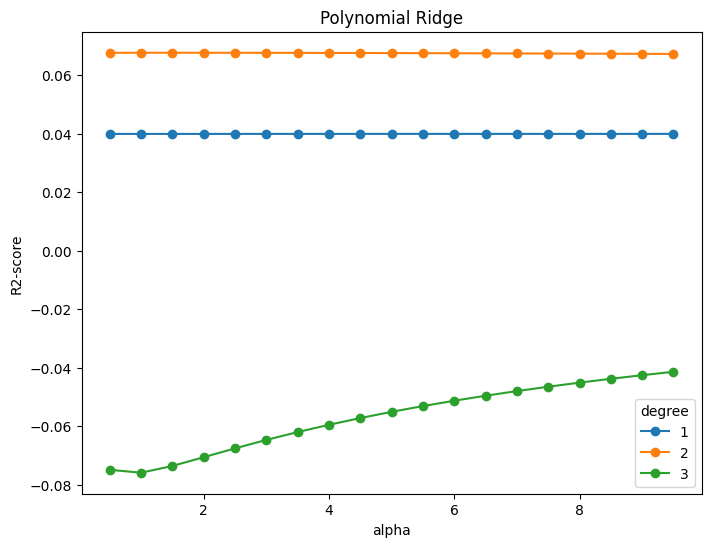

In [89]:
pivot_ridge.plot(xlabel='alpha', ylabel='R2-score', title='Polynomial Ridge',figsize=(8, 6), style='-o');

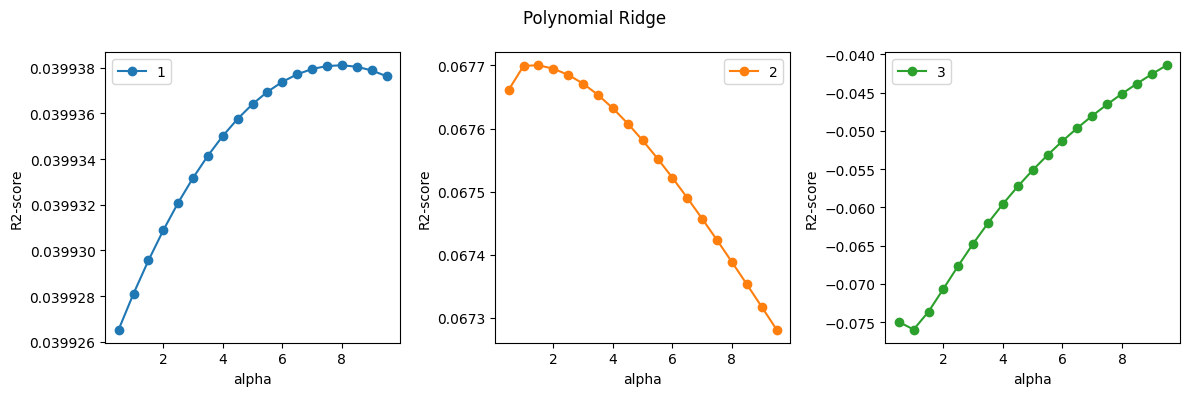

In [96]:
pivot_ridge.plot(ylabel='R2-score', title='Polynomial Ridge', subplots=True, layout=(1, 3), sharey=False, figsize=(12, 4), style='-o')
plt.tight_layout();

In [97]:
bestpoly_ridgeR2 = poly_ridge_scores.loc[poly_ridge_scores['R2'].idxmax()]
bestpoly_ridgeR2

name             Ridge
degree               2
alpha              1.5
max_iter          1000
R2              0.0677
MSE         445.183981
RMSE         21.099383
MAE          16.739326
MAPE          8.572374
Name: 105, dtype: object

### 1.9.2 Performance

In [98]:
degree = bestpoly_ridgeR2['degree']

X_train_poly, X_val_poly, X_test_poly = poly_fit(degree, X_train, X_val, X_test)

# model definition
polyridge = Ridge(alpha=bestpoly_ridgeR2['alpha'], max_iter=bestpoly_ridgeR2['max_iter'])

# model fit
polyridge.fit(X_train_poly, y_train)

Ridge(alpha=1.5, max_iter=1000)

**Training**

In [99]:
train_scores = register_performance(polyridge, 'Polynomial Regression Ridge', X_train_poly, y_train, train_scores)
train_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,0.000000,478.012560,21.863498,17.365090,8.742213
1,Linear Regression,0.046058,455.996112,21.354065,16.998249,8.653186
2,Decision Tree,0.113523,423.747268,20.585122,16.368766,7.869536
3,Random Forest,0.905269,45.282648,6.729238,4.819884,2.614952
4,Polynomial Regression,0.094195,432.986210,20.808321,16.458032,8.350540
5,Linear Regression Lasso,0.041219,458.309397,21.408162,17.046776,8.667964
6,Linear Regression Ridge,0.046018,456.015424,21.354518,16.999016,8.655050
7,Linear Regression Elastic Net,0.041219,458.309397,21.408162,17.046776,8.667964
8,Polynomial Regression Lasso,0.067909,445.551320,21.108087,16.743258,8.556924
9,Polynomial Regression Ridge,0.092837,433.635258,20.823911,16.476004,8.378145


**Validation**

In [100]:
val_scores = register_performance(polyridge, 'Polynomial Regression Ridge', X_val_poly, y_val, val_scores)
val_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-7.197077e-07,477.511956,21.852047,17.352836,8.678722
1,Linear Regression,3.992483e-02,458.447042,21.411376,17.039754,8.682542
2,Decision Tree,6.355928e-02,447.161319,21.146189,16.843452,8.395778
3,Random Forest,3.371453e-01,316.520801,17.791031,13.008747,7.019370
4,Polynomial Regression,6.647668e-02,445.768223,21.113224,16.749939,8.547931
5,Linear Regression Lasso,3.719533e-02,459.750411,21.441791,17.047448,8.686903
6,Linear Regression Ridge,3.993790e-02,458.440800,21.411231,17.037793,8.681461
7,Linear Regression Elastic Net,3.719533e-02,459.750411,21.441791,17.047448,8.686903
8,Polynomial Regression Lasso,5.889836e-02,449.386960,21.198749,16.818893,8.667648
9,Polynomial Regression Ridge,6.770020e-02,445.183981,21.099383,16.739326,8.572374


**Test**

In [101]:
test_scores = register_performance(polyridge, 'Polynomial Regression Ridge', X_test_poly, y_test, test_scores)
test_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-0.000124,486.961469,22.067203,17.551492,8.714550
1,Linear Regression,0.052317,461.427719,21.480869,17.129965,8.521859
2,Decision Tree,0.072181,451.755789,21.254547,17.010757,7.833952
3,Random Forest,0.356790,313.179616,17.696882,12.981922,6.545300
4,Polynomial Regression,0.090079,443.041256,21.048545,16.720535,8.242464
5,Linear Regression Lasso,0.044728,465.122726,21.566704,17.175600,8.592947
6,Linear Regression Ridge,0.052199,461.485049,21.482203,17.128327,8.529799
7,Linear Regression Elastic Net,0.044728,465.122726,21.566704,17.175600,8.592947
8,Polynomial Regression Lasso,0.070407,452.619970,21.274867,16.912310,8.454671
9,Polynomial Regression Ridge,0.088758,443.684800,21.063827,16.732546,8.297960


## 1.10 Polynomial Regression Elastic Net

O algoritmo Polynomial Regression Ridge vai ser implementado calculando-se os termos de um polinômio via classe `PolynomialFeatures` e treinando os valores resultantes com a classe `ElasticNet`.

Parâmetros para se estimar:

* `degree` = grau do polinômio da regressão polinomial.
* `alpha` = constante que multiplica os termos de penalidade ($\alpha = \lambda_1 + \lambda_2$)
* `l1_ratio` = parâmetro que define a proporção entre as penalidades L1 e L2 ( $L_1 = \lambda_1 \;/\; (\lambda_1 + \lambda_2)$ )
* `max_iter` = número máximo de iterações permitida durante a busca pelos melhores parâmetros.

### 1.10.1 Fine-tuning

In [102]:
poly_elastic_scores = ml_training(
                                    ElasticNet,
                                    'regression', X_train, y_train, X_val, y_val,
                                    degree=[1, 2, 3],
                                    alpha=np.linspace(0.1, 1, 10),
                                    l1_ratio=np.linspace(0.1, 1, 10),
                                    max_iter=[1000, 1500, 2000]
                    )

poly_elastic_scores

,name,degree,alpha,l1_ratio,max_iter,R2,MSE,RMSE,MAE,MAPE
0,ElasticNet,1,0.1,0.1,1000,0.025559,465.306951,21.570975,17.121044,8.677026
1,ElasticNet,1,0.1,0.1,1500,0.025559,465.306951,21.570975,17.121044,8.677026
2,ElasticNet,1,0.1,0.1,2000,0.025559,465.306951,21.570975,17.121044,8.677026
3,ElasticNet,1,0.1,0.2,1000,0.026096,465.050533,21.565030,17.116586,8.676744
4,ElasticNet,1,0.1,0.2,1500,0.026096,465.050533,21.565030,17.116586,8.676744
...,...,...,...,...,...,...,...,...,...,...
895,ElasticNet,3,1.0,0.9,1500,0.014073,470.791570,21.697732,17.184438,8.655556
896,ElasticNet,3,1.0,0.9,2000,0.014073,470.791570,21.697732,17.184438,8.655556
897,ElasticNet,3,1.0,1.0,1000,0.014148,470.755769,21.696907,17.180595,8.655828
898,ElasticNet,3,1.0,1.0,1500,0.014148,470.755769,21.696907,17.180595,8.655828


In [106]:
# poly_elastic_scores.to_csv('output/regression/polynomial_elasticnet.csv', index=False)
poly_elastic_scores = pd.read_csv('output/regression/polynomial_elasticnet.csv')

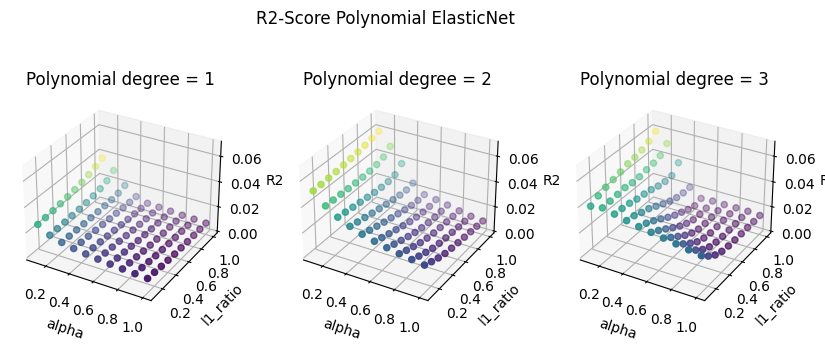

In [113]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), subplot_kw=dict(projection='3d'))

for i, ax in enumerate(axes):
    
    degree_n = poly_elastic_scores.query(f'degree == {i+1}')
    degree_n = degree_n.drop('degree', axis=1).groupby(['alpha', 'l1_ratio']).mean(numeric_only=True).reset_index()
    
    x = degree_n['alpha']
    y = degree_n['l1_ratio']
    z = degree_n['R2']

    scatter_plot = ax.scatter3D(xs=x, ys=y, zs=z, c=z)

    ax.set_xlabel('alpha')
    ax.set_ylabel('l1_ratio')
    ax.set_zlabel('R2')
    ax.set_title('Polynomial degree = {}'.format(i+1))
    ax.set_zlim((0, 0.07))


fig.subplots_adjust(right=0.9, wspace=0.25)

fig.suptitle('R2-Score Polynomial ElasticNet');

In [114]:
bestpoly_elasticR2 = poly_elastic_scores.loc[poly_elastic_scores['R2'].idxmax()]
bestpoly_elasticR2

name        ElasticNet
degree               2
alpha              0.1
l1_ratio           1.0
max_iter          1000
R2            0.058898
MSE          449.38696
RMSE         21.198749
MAE          16.818893
MAPE          8.667648
Name: 327, dtype: object

### 1.10.2 Performance

In [115]:
degree = bestpoly_elasticR2['degree']

X_train_poly, X_val_poly, X_test_poly = poly_fit(degree, X_train, X_val, X_test)

# model definition
polyelastic = ElasticNet(
                            alpha=bestpoly_elasticR2['alpha'],
                            l1_ratio=bestpoly_elasticR2['l1_ratio'],
                            max_iter=bestpoly_elasticR2['max_iter']
                )

# model fit
polyelastic.fit(X_train_poly, y_train)

ElasticNet(alpha=0.1, l1_ratio=1.0)

**Training**

In [116]:
train_scores = register_performance(polyelastic, 'Polynomial Regression Elastic Net', X_train_poly, y_train, train_scores)
train_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,0.000000,478.012560,21.863498,17.365090,8.742213
1,Linear Regression,0.046058,455.996112,21.354065,16.998249,8.653186
2,Decision Tree,0.113523,423.747268,20.585122,16.368766,7.869536
3,Random Forest,0.905269,45.282648,6.729238,4.819884,2.614952
4,Polynomial Regression,0.094195,432.986210,20.808321,16.458032,8.350540
5,Linear Regression Lasso,0.041219,458.309397,21.408162,17.046776,8.667964
6,Linear Regression Ridge,0.046018,456.015424,21.354518,16.999016,8.655050
7,Linear Regression Elastic Net,0.041219,458.309397,21.408162,17.046776,8.667964
8,Polynomial Regression Lasso,0.067909,445.551320,21.108087,16.743258,8.556924
9,Polynomial Regression Ridge,0.092837,433.635258,20.823911,16.476004,8.378145


**Validation**

In [117]:
val_scores = register_performance(polyelastic, 'Polynomial Regression Elastic Net', X_val_poly, y_val, val_scores)
val_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-7.197077e-07,477.511956,21.852047,17.352836,8.678722
1,Linear Regression,3.992483e-02,458.447042,21.411376,17.039754,8.682542
2,Decision Tree,6.355928e-02,447.161319,21.146189,16.843452,8.395778
3,Random Forest,3.371453e-01,316.520801,17.791031,13.008747,7.019370
4,Polynomial Regression,6.647668e-02,445.768223,21.113224,16.749939,8.547931
5,Linear Regression Lasso,3.719533e-02,459.750411,21.441791,17.047448,8.686903
6,Linear Regression Ridge,3.993790e-02,458.440800,21.411231,17.037793,8.681461
7,Linear Regression Elastic Net,3.719533e-02,459.750411,21.441791,17.047448,8.686903
8,Polynomial Regression Lasso,5.889836e-02,449.386960,21.198749,16.818893,8.667648
9,Polynomial Regression Ridge,6.770020e-02,445.183981,21.099383,16.739326,8.572374


**Test**

In [118]:
test_scores = register_performance(polyelastic, 'Polynomial Regression Elastic Net', X_test_poly, y_test, test_scores)
test_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-0.000124,486.961469,22.067203,17.551492,8.714550
1,Linear Regression,0.052317,461.427719,21.480869,17.129965,8.521859
2,Decision Tree,0.072181,451.755789,21.254547,17.010757,7.833952
3,Random Forest,0.356790,313.179616,17.696882,12.981922,6.545300
4,Polynomial Regression,0.090079,443.041256,21.048545,16.720535,8.242464
5,Linear Regression Lasso,0.044728,465.122726,21.566704,17.175600,8.592947
6,Linear Regression Ridge,0.052199,461.485049,21.482203,17.128327,8.529799
7,Linear Regression Elastic Net,0.044728,465.122726,21.566704,17.175600,8.592947
8,Polynomial Regression Lasso,0.070407,452.619970,21.274867,16.912310,8.454671
9,Polynomial Regression Ridge,0.088758,443.684800,21.063827,16.732546,8.297960


# 2.0 Summary

In [122]:
# train_scores.to_csv('output/regression/train_scores.csv', index=False)
train_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,0.000000,478.012560,21.863498,17.365090,8.742213
1,Linear Regression,0.046058,455.996112,21.354065,16.998249,8.653186
2,Decision Tree,0.113523,423.747268,20.585122,16.368766,7.869536
3,Random Forest,0.905269,45.282648,6.729238,4.819884,2.614952
4,Polynomial Regression,0.094195,432.986210,20.808321,16.458032,8.350540
5,Linear Regression Lasso,0.041219,458.309397,21.408162,17.046776,8.667964
6,Linear Regression Ridge,0.046018,456.015424,21.354518,16.999016,8.655050
7,Linear Regression Elastic Net,0.041219,458.309397,21.408162,17.046776,8.667964
8,Polynomial Regression Lasso,0.067909,445.551320,21.108087,16.743258,8.556924
9,Polynomial Regression Ridge,0.092837,433.635258,20.823911,16.476004,8.378145


In [123]:
# val_scores.to_csv('output/regression/val_scores.csv', index=False)
val_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-7.197077e-07,477.511956,21.852047,17.352836,8.678722
1,Linear Regression,3.992483e-02,458.447042,21.411376,17.039754,8.682542
2,Decision Tree,6.355928e-02,447.161319,21.146189,16.843452,8.395778
3,Random Forest,3.371453e-01,316.520801,17.791031,13.008747,7.019370
4,Polynomial Regression,6.647668e-02,445.768223,21.113224,16.749939,8.547931
5,Linear Regression Lasso,3.719533e-02,459.750411,21.441791,17.047448,8.686903
6,Linear Regression Ridge,3.993790e-02,458.440800,21.411231,17.037793,8.681461
7,Linear Regression Elastic Net,3.719533e-02,459.750411,21.441791,17.047448,8.686903
8,Polynomial Regression Lasso,5.889836e-02,449.386960,21.198749,16.818893,8.667648
9,Polynomial Regression Ridge,6.770020e-02,445.183981,21.099383,16.739326,8.572374


In [124]:
# test_scores.to_csv('output/regression/test_scores.csv', index=False)
test_scores

,Algorithm,R2,MSE,RMSE,MAE,MAPE
0,Baseline,-0.000124,486.961469,22.067203,17.551492,8.714550
1,Linear Regression,0.052317,461.427719,21.480869,17.129965,8.521859
2,Decision Tree,0.072181,451.755789,21.254547,17.010757,7.833952
3,Random Forest,0.356790,313.179616,17.696882,12.981922,6.545300
4,Polynomial Regression,0.090079,443.041256,21.048545,16.720535,8.242464
5,Linear Regression Lasso,0.044728,465.122726,21.566704,17.175600,8.592947
6,Linear Regression Ridge,0.052199,461.485049,21.482203,17.128327,8.529799
7,Linear Regression Elastic Net,0.044728,465.122726,21.566704,17.175600,8.592947
8,Polynomial Regression Lasso,0.070407,452.619970,21.274867,16.912310,8.454671
9,Polynomial Regression Ridge,0.088758,443.684800,21.063827,16.732546,8.297960
